In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import pickle


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_statistics = pd.read_csv("Statistics.csv")

In [ ]:
df_statistics

,Unnamed: 0,pickup_hour,pickup_location,dropoff_location,trip_distance,trip_time_in_secs,total_amount,number_of_transitions,count,counts,transition_probability
0,0,0.0,7002,7002,1.660000,420.000000,44.500000,2,2.0,2,1.000000
1,1,0.0,7008,7008,2.230000,660.000000,11.000000,1,1.0,1,1.000000
2,2,0.0,7011,7011,0.000000,0.000000,5.000000,1,1.0,1,1.000000
3,3,0.0,7017,10018,3.420000,1500.000000,19.000000,1,1.0,1,1.000000
4,4,0.0,7020,10003,7.610000,1500.000000,32.900000,1,8.0,8,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
71914,71914,23.0,97003,10020,1.340000,420.000000,8.000000,1,NaN,546,0.001832
71915,71915,23.0,97003,10065,1.510000,300.000000,7.500000,1,NaN,546,0.001832
71916,71916,23.0,97003,11024,0.000000,0.000000,110.400000,1,NaN,546,0.001832
71917,71917,23.0,97003,11211,3.640000,1020.000000,16.000000,1,NaN,546,0.001832


In [ ]:
listed_pickup_zipcodes = df_statistics['pickup_location'].unique()
listed_dropoff_zipcodes = df_statistics['dropoff_location'].unique()

zipcodes = list(set([*listed_pickup_zipcodes, *listed_dropoff_zipcodes]))

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
class CabDriver():
    def __init__(self, cost, zipcodes):
        self.t = 24
        self.m = 60
        self.zipcode_count = len(zipcodes)
        self.zipcodes = zipcodes
        self.action_space = [(p,q) for p in zipcodes for q in zipcodes]
        self.action_space.insert(0,(-1,-1))
        self.state_space = [(x,z, y) for x in range(self.t) for z in range(self.m) for y in zipcodes]
        self.state_init = self.state_space[np.random.choice(len(self.state_space))]
        self.cost = cost
        self.reset()

    def state_encoder(self, state):
        curr_hour,curr_min, curr_loc= state

        ## Initialize arrays
        state_encodings = np.zeros(self.zipcode_count+self.t+self.m, dtype=int)
        state_encodings[self.zipcodes.index(curr_loc)] = 1
        state_encodings[self.zipcode_count+curr_hour] = 1
        state_encodings[self.zipcode_count+self.t+ curr_min] = 1

        return state_encodings

    def requests(self, state):
        curr_hour,_, curr_loc= state
        actions_in_hour = [tuple(x)for x in df_statistics[(df_statistics["pickup_hour"]==curr_hour)].sort_values(by=["total_amount"],ascending=False)[["pickup_location","dropoff_location"]].head(10).to_records(index=False)]
        # requests = np.random.poisson(10)
        # possible_actions = random.sample(actions_in_hour, requests) + [(-1,-1)]
        return actions_in_hour

    def update_time(self, curr_hour, curr_minute, ride_duration):
        ride_duration = int(ride_duration)
        curr_second =  curr_hour * 3600 + curr_minute * 60 + ride_duration
        m, s = divmod(curr_second, 60)
        h, m = divmod(m, 60)
        return h, m

    def get_duration(self, curr_hour, pickup_loc, dropoff_loc):
        temp = df_statistics[(df_statistics["pickup_hour"]==curr_hour) & (df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          temp = df_statistics[(df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          return 15*60; # max duration is 15 minutes for a pickup
        else:
          return temp["trip_time_in_secs"].mean()

    def get_reward(self, curr_hour, pickup_loc, dropoff_loc):
        temp = df_statistics[(df_statistics["pickup_hour"]==curr_hour) & (df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          temp = df_statistics[(df_statistics["pickup_location"] == pickup_loc) & (df_statistics["dropoff_location"] == dropoff_loc)]
        if(temp.empty):
          return 0; # max duration is 15 minutes for a pickup
        else:
          return temp["total_amount"].mean()

    def get_next_state_and_time_func(self, state, action):
        next_state = []

        # Initialize various times
        total_time   = 0
        transit_time = 0
        wait_time = 0
        ride_time    = 0

        curr_hour,curr_min, curr_loc = state
        pickup_loc, drop_loc= action

        """
         3 Possible Scenarios:
           i) Refuse all requests. Engage in Idle Time (wait: 1hr (i.e. 1 time unit))
           ii) Driver is already at the pickup spot
           iii) Driver is not at the pickup spot
        """
        if ((pickup_loc== -1) and (drop_loc == -1)):
            wait_time = 3600
            next_loc = curr_loc
            reward = 0
        elif (curr_loc == pickup_loc):
            ride_time = self.get_duration(curr_hour, pickup_loc, drop_loc)
            next_loc = drop_loc
            reward = self.get_reward(curr_hour, pickup_loc, drop_loc)
        else:
            transit_time      = self.get_duration(curr_hour,curr_loc, pickup_loc)
            new_hour, new_min = self.update_time(curr_hour,curr_min, transit_time)

            ride_time = self.get_duration(curr_hour, pickup_loc, drop_loc)
            next_loc  = drop_loc
            reward = self.get_reward(curr_hour, pickup_loc, drop_loc)

        # Calculate total time as sum of all durations
        total_time = (wait_time + transit_time + ride_time)
        next_hour, next_min = self.update_time(curr_hour, curr_min, total_time)

        # Finding next_state using the next_loc and the next time states.
        next_state = (next_hour, next_min, next_loc)

        return next_state,reward, wait_time, transit_time, ride_time

    def reward_func(self, reward, wait_time, transit_time, ride_time):
        """Takes in state, action and Time-matrix and returns the reward"""
        if wait_time + transit_time > 0:
            reward = reward - self.cost

        return reward

    def step(self, state, action):
        """
        Take a trip as cabby to get rewards next step and total time spent
        """
        # Get the next state and the various time durations
        next_state,reward, wait_time, transit_time, ride_time = self.get_next_state_and_time_func(state, action)
        # print(next_state,reward, wait_time, transit_time, ride_time)

        rewards = self.reward_func(reward, wait_time, transit_time, ride_time)
        total_time = wait_time + transit_time + ride_time

        return rewards, next_state, total_time

    def reset(self):
        return self.action_space, self.state_space, self.state_init


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 500
        self.epsilon_min = 0.01
        self.gamma = 0.99

        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []

        # create main model and target model
        self.q_net_a, self.q_net_b, self.target_net = self.build_model()

        self.optimizer_a = optim.Adam(self.q_net_a.parameters(), lr=0.00001)
        self.optimizer_b = optim.Adam(self.q_net_b.parameters(), lr=0.00001)

    def get_epsilon(self, step):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-step / self.epsilon_decay)

    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        q_net_a = DQN(self.state_size, self.action_size)
        q_net_b = DQN(self.state_size, self.action_size)
        target_net = DQN(self.state_size, self.action_size)
        target_net.load_state_dict(q_net_a.state_dict())
        q_net_a.to(device)
        q_net_b.to(device)
        target_net.to(device)
        return q_net_a, q_net_b, target_net

    def select_action(self,state, q_net, epsilon, action_space):
        if np.random.rand() < self.epsilon:
            return random.choice(action_space)
        else:
            with torch.no_grad():
                return action_space[torch.argmax(q_net(torch.Tensor(state))).item()]

    def append_sample(self, state, action, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self, q_net_value, target_net, optimizer):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1).to(device)
            res = q_net_value(states)
            q_values = torch.gather(res, dim=1, index=actions)

            with torch.no_grad():
                next_q_values = torch.max(target_net(next_states), dim=1, keepdim=True)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

            loss = torch.mean((q_values - target_q_values) ** 2)
            # print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    def save(self, name):
        with open(name, 'wb') as file:
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [ ]:
class RandomAgent:
    def __init__(self):
      pass

    def select_action(self,action_space):
        return random.choice(action_space)

In [ ]:
episode_time = 24* 60*60
n_episodes = 5000
max_steps = 200
env = CabDriver(zipcodes=zipcodes,cost = 3)
action_space, state_space, state = env.reset()

state_size = env.state_encoder(state_space[0])
action_size = len(action_space)

# Invoke agent class
ddqn_agent = DQNAgent(action_size=action_size, state_size=len(state_size))
randomAgent = RandomAgent()
rewards_per_episode, episodes = [], []

In [ ]:
for episode in range(n_episodes):
    _,_, state = env.reset()
    score = 0
    epsilon = ddqn_agent.get_epsilon(episode)
    ddqn_done = False
    for step in range(max_steps):
        if step % 2 == 0:
            optimizer, q_net, target_net = ddqn_agent.optimizer_a, ddqn_agent.q_net_a, ddqn_agent.q_net_b
        else:
            optimizer, q_net, target_net = ddqn_agent.optimizer_b, ddqn_agent.q_net_b, ddqn_agent.q_net_a

        requests = env.requests(state)
        ddqn_action = ddqn_agent.select_action(state, q_net, epsilon, requests)
        ddqn_reward, ddqn_next_state, ddqn_duration =  env.step(state, ddqn_action)
        ddqn_next_state_hour, ddqn_next_state_min, _ = ddqn_next_state
        if(ddqn_next_state_hour * 3600 + ddqn_next_state_min * 60 >= episode_time):
          break
        else:
          ddqn_agent.append_sample(env.state_encoder(state), env.action_space.index(ddqn_action), ddqn_reward, env.state_encoder(ddqn_next_state), False)
          ddqn_agent.train_model(q_net, target_net, optimizer)
          score += ddqn_reward
          state = ddqn_next_state
    rewards_per_episode.append(score)
    if episode % 100 == 0:
          print(f"Episode {episode}: Reward = {score}")

Episode 0: Reward = 117.0
Episode 100: Reward = 117.1
Episode 200: Reward = 265.55
Episode 300: Reward = 117.0
Episode 400: Reward = 256.05
Episode 500: Reward = 143.0
Episode 600: Reward = 143.0
Episode 700: Reward = 286.55
Episode 800: Reward = 117.1
Episode 900: Reward = 147.5
Episode 1000: Reward = 428.6
Episode 1100: Reward = 121.1
Episode 1200: Reward = 152.25
Episode 1300: Reward = 150.75
Episode 1400: Reward = 124.05
Episode 1500: Reward = 147.5
Episode 1600: Reward = 117.1
Episode 1700: Reward = 147.5
Episode 1800: Reward = 240.64999999999998
Episode 1900: Reward = 124.05
Episode 2000: Reward = 152.25
Episode 2100: Reward = 265.55
Episode 2200: Reward = 143.0
Episode 2300: Reward = 117.1
Episode 2400: Reward = 256.15
Episode 2500: Reward = 121.1
Episode 2600: Reward = 256.05
Episode 2700: Reward = 121.1
Episode 2800: Reward = 150.75
Episode 2900: Reward = 143.0
Episode 3000: Reward = 265.55
Episode 3100: Reward = 147.5
Episode 3200: Reward = 404.6
Episode 3300: Reward = 117.1


In [ ]:
plt.plot(range(1000), rewards_per_episode)

In [ ]:
class NDQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 500
        self.epsilon_min = 0.01
        self.gamma = 0.99

        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []

        # create main model and target model
        self.q_net, self.target_net = self.build_model()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=0.00001)

    def get_epsilon(self, step):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-step / self.epsilon_decay)

    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        q_net_a = DQN(self.state_size, self.action_size)
        target_net = DQN(self.state_size, self.action_size)
        target_net.load_state_dict(q_net_a.state_dict())
        q_net_a.to(device)
        target_net.to(device)
        return q_net_a, target_net

    def select_action(self,state, epsilon, action_space):
        if np.random.rand() < self.epsilon:
            return random.choice(action_space)
        else:
            with torch.no_grad():
                return action_space[torch.argmax(self.q_net(torch.Tensor(state))).item()]

    def append_sample(self, state, action, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1).to(device)
            res = self.q_net(states)
            q_values = torch.gather(res, dim=1, index=actions)

            with torch.no_grad():
                next_q_values = torch.max(self.target_net(next_states), dim=1, keepdim=True)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

            loss = torch.mean((q_values - target_q_values) ** 2)
            # print(loss)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def save(self, name):
        with open(name, 'wb') as file:
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [ ]:
n_agent = NDQNAgent(action_size=action_size, state_size=len(state_size))
n_rewards_per_episode = []
update_target_net_freq = 50

In [ ]:
for episode in range(n_episodes):
    _,_, state = env.reset()
    score = 0
    epsilon = n_agent.get_epsilon(episode)
    for step in range(max_steps):
        requests = env.requests(state)
        action = n_agent.select_action(state, epsilon, requests)
        reward, next_state, duration =  env.step(state, action)
        next_state_hour, next_state_min, _ = next_state
        if(next_state_hour * 3600 + next_state_min * 60 >= episode_time):
          break
        else:
          n_agent.append_sample(env.state_encoder(state), env.action_space.index(action), reward, env.state_encoder(next_state), False)
          n_agent.train_model()
          score += reward
          state = next_state
    n_rewards_per_episode.append(score)
    if episode % 100 == 0:
          print(f"Episode {episode}: Reward = {score}")
    if episode % update_target_net_freq == 0:
            n_agent.target_net.load_state_dict(q_net.state_dict())

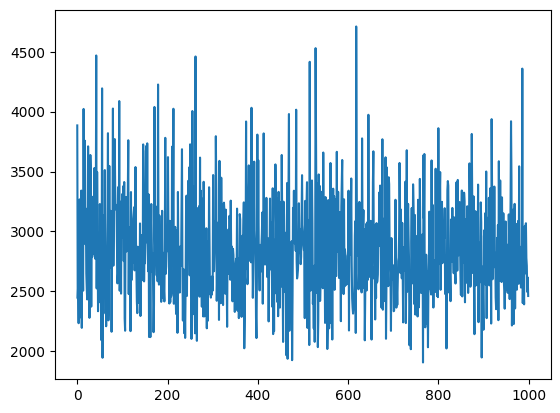

In [ ]:
plt.plot(n_episodes, n_rewards_per_episode[1000:])

In [ ]:
random_rewards_per_episode = []

for episode in range(n_episodes):
    _,_,state = env.reset()
    score = 0
    for step in range(max_steps):
        requests = env.requests(state)
        action = randomAgent.select_action(requests)
        reward, next_state, duration = env.step(state, action)
        next_state_hour, next_state_min, _ = next_state
        if(next_state_hour * 3600 + next_state_min * 60 >= episode_time):
          break
        else:
          score += reward
          state = next_state
    random_rewards_per_episode.append(score)
    if episode % 100 == 0:
          print(f"Episode {episode}: Reward = {score}")


Episode 0: Reward = 2457.0049999999997
Episode 100: Reward = 2311.1
Episode 200: Reward = 2892.8100000000004
Episode 300: Reward = 3307.3500000000004
Episode 400: Reward = 2893.36
Episode 500: Reward = 3046.4000000000005
Episode 600: Reward = 2900.2300000000005
Episode 700: Reward = 2533.7999999999997
Episode 800: Reward = 2804.9300000000003
Episode 900: Reward = 2636.02


In [ ]:
plt.plot(range(n_episodes), random_rewards_per_episode)

In [ ]:
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = np.random.random()
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    action = env.action_space.sample() # Take a random action

  return action





In [ ]:
def train(self, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in range(n_training_episodes):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # Reset the environment
        _, _, state = env.reset()
        step = 0
        score = 0

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            reward, next_state, duration =  env.step(state, action)
            score += reward

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s') - Q(s,a)]
            Qtable[state][action] += learning_rate * (reward + gamma*np.max(Qtable[new_state].values()) - Qtable[state][action])

            # Our state is the new state
            state = new_state
        return Qtable

In [ ]:
zipcodes = [1, 2, 3]

In [ ]:
class QLearningAgent():
    def __init__(self, zipcodes):
        self.t = 24
        self.m = 60
        self.Qtable = {(i, z, y): {(z1, z2): 0 for z1 in zipcodes for z2 in zipcodes} for i in range(self.t) for z in range(self.m) for y in zipcodes}

    def train(self, n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps):
        for episode in range(n_training_episodes):
            # Reduce epsilon (because we need less and less exploration)
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            # Reset the environment
            _, _, state = env.reset()
            step = 0
            score = 0

            # repeat
            for step in range(max_steps):
                # Choose the action At using epsilon greedy policy
                requests = env.requests(state)
                action = epsilon_greedy_policy(Qtable, state, epsilon, requests)
                # Take action At and observe Rt+1 and St+1
                # Take the action (a) and observe the outcome state(s') and reward (r)
                reward, next_state, duration =  env.step(state, action)
                score += reward

                # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s') - Q(s,a)]
                Qtable[state][action] += learning_rate * (reward + gamma*np.max(Qtable[new_state].values()) - Qtable[state][action])

                # Our state is the new state
                state = new_state
            return Qtable

    def choose_action(self, state, epsilon, available_actions):
        """Choose an action based on the state using an epsilon-greedy policy."""
        if np.random.rand() <= epsilon:
            return random.choice(available_actions)
        else:
            # choose the current best from q_table
            return avaliable_actions[np.argmax([self.Qtable[state][action] for action in available_actions])]

In [ ]:
sas = QLearningAgent(zipcodes)

In [ ]:
sas.Qtable

{(0, 0, 1): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 0, 2): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 0, 3): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 1, 1): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 1, 2): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 1, 3): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 2, 1): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1): 0,
  (3, 2): 0,
  (3, 3): 0},
 (0, 2, 2): {(1, 1): 0,
  (1, 2): 0,
  (1, 3): 0,
  (2, 1): 0,
  (2, 2): 0,
  (2, 3): 0,
  (3, 1)

In [ ]:
class SARSAAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state, available_actions):
        """Choose an action based on the state using an epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.choice(available_actions)
        else:
            q_values = self.q_table[state, :]
            max_value = np.max(q_values[available_actions])
            best_actions = [action for action in available_actions if q_values[action] == max_value]
            return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state, next_action):
        """Update the Q-table using the SARSA update rule."""
        predict = self.q_table[state, action]
        target = reward + self.discount_factor * self.q_table[next_state, next_action]
        self.q_table[state, action] += self.learning_rate * (target - predict)

    def update_epsilon(self):
        """Update epsilon using exponential decay to reduce the exploration rate over time."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path='sarsa_q_table.npy'):
        """Save the trained Q-table for later use."""
        np.save(path, self.q_table)

    def load(self, path='sarsa_q_table.npy'):
        """Load a Q-table from disk."""
        self.q_table = np.load(path)

In [ ]:
episode_time = 24*60*60
n_episodes = 5000
max_steps = 200
env = CabDriver(zipcodes=zipcodes, cost = 3)
action_space, state_space, state = env.reset()

state_size = len(state_space)
print(state_size)
action_size = len(action_space)
print(action_size)

# Invoke agent class
sarsa_agent = SARSAAgent(state_size=state_size, action_size=action_size)
sarsa_rewards_per_episode, episodes = [], []
actions_taken = []

def state_to_index(state, t=24, m=60, zipcodes=None):
    hour, minute, location = state
    location_index = zipcodes.index(location) if zipcodes is not None and location in zipcodes else location
    return hour * (m * len(zipcodes)) + minute * len(zipcodes) + location_index

898560
389377


In [10]:
for episode in range(n_episodes):
    _, _, sarsa_state = env.reset()
    sarsa_score = 0
    available_actions = env.requests(sarsa_state)
    state_index = state_to_index(sarsa_state, zipcodes=env.zipcodes)
    available_action_indices = [env.action_space.index(action) for action in available_actions]
    sarsa_action = sarsa_agent.choose_action(state_index, available_action_indices)

    for step in range(max_steps):
        actions_taken.append(sarsa_action)
        sarsa_reward, sarsa_next_state, _ = env.step(sarsa_state, env.action_space[sarsa_action])
        sarsa_next_state_hour, sarsa_next_state_min, _ = sarsa_next_state

        if (sarsa_next_state_hour * 3600 + sarsa_next_state_min * 60 >= episode_time):
            break

        available_next_actions = env.requests(sarsa_next_state)
        next_state_index = state_to_index(sarsa_next_state, zipcodes=env.zipcodes)
        available_next_action_indices = [env.action_space.index(action) for action in available_next_actions]
        sarsa_next_action = sarsa_agent.choose_action(next_state_index, available_next_action_indices)

        sarsa_agent.update_q_value(sarsa_state, sarsa_action,
                                   sarsa_reward, sarsa_next_state, sarsa_next_action)

        sarsa_state = sarsa_next_state
        sarsa_action = sarsa_next_action
        sarsa_score += sarsa_reward

    sarsa_rewards_per_episode.append(sarsa_score)
    sarsa_agent.update_epsilon()

    if episode % 100 == 0:
        print(f"SARSA Episode {episode}: Reward = {sarsa_score}")
        # sarsa_agent.save(f'sarsa_q_table_{episode}.npy')

SARSA Episode 0: Reward = 2052.8
SARSA Episode 100: Reward = 1961.4499999999998
SARSA Episode 200: Reward = 2652.17
SARSA Episode 300: Reward = 1505.7999999999997
SARSA Episode 400: Reward = 2125.21
SARSA Episode 500: Reward = 1914.55
SARSA Episode 600: Reward = 1553.8
SARSA Episode 700: Reward = 1134.1100000000001
SARSA Episode 800: Reward = 2998.79
SARSA Episode 900: Reward = 1951.65
SARSA Episode 1000: Reward = 3233.5200000000004
SARSA Episode 1100: Reward = 1299.7999999999997
SARSA Episode 1200: Reward = 1525.16
SARSA Episode 1300: Reward = 1506.4499999999998
SARSA Episode 1400: Reward = 2630.5499999999997
SARSA Episode 1500: Reward = 1777.1599999999999
SARSA Episode 1600: Reward = 1937.8400000000001
SARSA Episode 1700: Reward = 1764.3
SARSA Episode 1800: Reward = 2390.125
SARSA Episode 1900: Reward = 1693.85
SARSA Episode 2000: Reward = 1816.7599999999998
SARSA Episode 2100: Reward = 1671.81
SARSA Episode 2200: Reward = 1499.3
SARSA Episode 2300: Reward = 1709.1299999999999
SARSA 

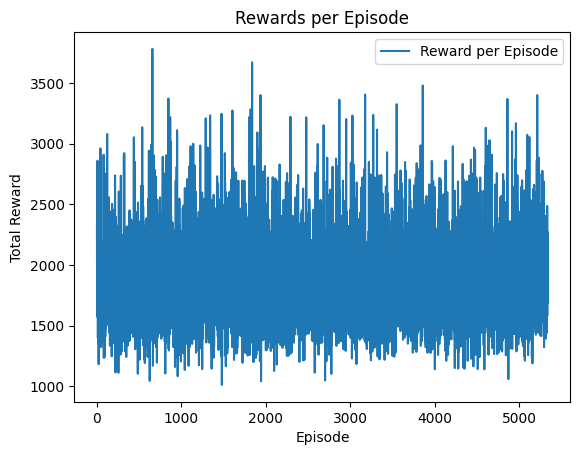

In [14]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))
plt.plot(range(len(sarsa_rewards_per_episode)), sarsa_rewards_per_episode, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.show()


In [20]:
print(np.mean(sarsa_rewards_per_episode), np.std(sarsa_rewards_per_episode))

1861.2253529962547 358.46985922334244


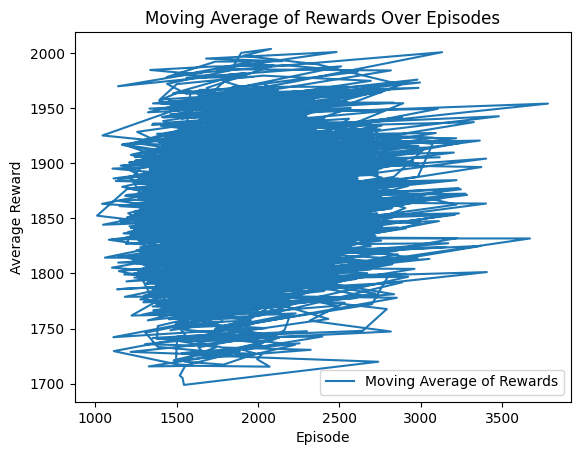

In [17]:
window_size = 50
moving_avg_rewards = [np.mean(sarsa_rewards_per_episode[i:i+window_size]) for i in range(len(sarsa_rewards_per_episode)-window_size)]
# plt.figure(figsize=(12, 5))
plt.plot(sarsa_rewards_per_episode[:-window_size], moving_avg_rewards, label='Moving Average of Rewards')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Moving Average of Rewards Over Episodes')
plt.legend()
plt.show()


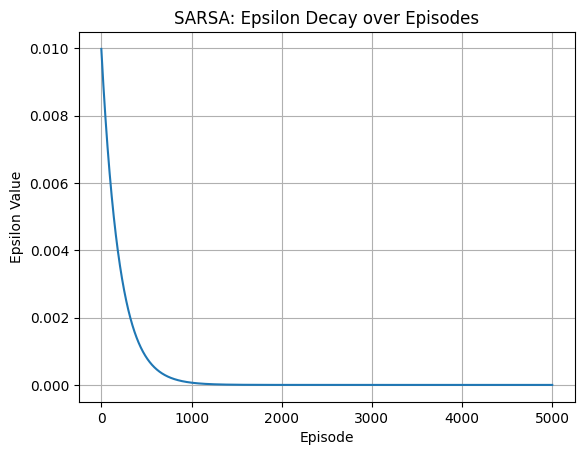

In [18]:
epsilon_values = [sarsa_agent.epsilon * (sarsa_agent.epsilon_decay ** i) for i in range(n_episodes)]
# plt.figure(figsize=(12, 5))
plt.plot(range(n_episodes), epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('SARSA: Epsilon Decay over Episodes')
plt.grid(True)
plt.show()


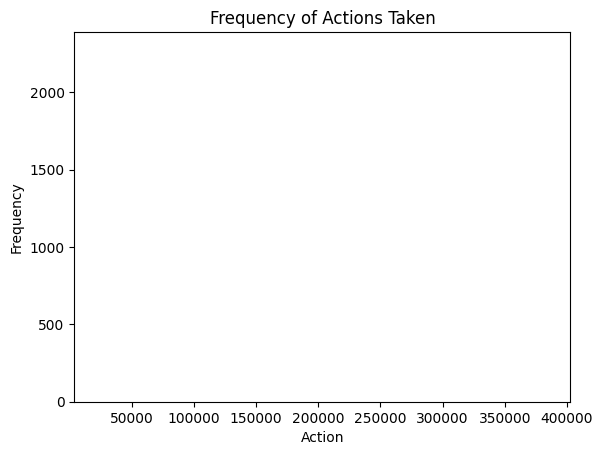

In [19]:
from collections import Counter

action_counts = Counter(actions_taken)
# plt.figure(figsize=(12, 5))
plt.bar(action_counts.keys(), action_counts.values())
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.title('Frequency of Actions Taken')
plt.show()
